- 참고 : https://sieon-dev.tistory.com/15

## 1. 모듈 import (필요없는 모듈 삭제, 필요한 모듈 추가하면서 진행)
- pandas
- numpy
- matplotlib
- re
- konlpy
- tensorflow
- seaborn
- pandas_profiling

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tqdm import tqdm
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import pandas_profiling

In [2]:
import sklearn
from sklearn.model_selection import train_test_split

In [3]:
import collections
from collections import Counter

In [4]:
import exchange_calendars as ecals
import datetime
import time

### 1-1. 파이썬 & 모듈 버전 확인 (필요없는 모듈 삭제, 필요한 모듈 추가하면서 진행)

In [5]:
print(" python version : ", sys.version, "\n", "-" * 100)
print(" pandas version : ", pd.__version__, "\n", "-" * 100)
print(" numpy version : ", np.__version__, "\n", "-" * 100)
print(" re version : ", re.__version__, "\n", "-" * 100)
print(" tensorflow version : ", tensorflow.__version__, "\n", "-" * 100)
print(" seaborn version : ", sns.__version__, "\n", "-" * 100)
print(" pandas_profiling version : ", pandas_profiling.__version__, "\n", "-" * 100)
print(" sklearn version : ", sklearn.__version__, "\n", "-" * 100)
print(" exhange_calendars version : ", ecals.__version__, "\n", "-" * 100)

 python version :  3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)] 
 ----------------------------------------------------------------------------------------------------
 pandas version :  1.2.4 
 ----------------------------------------------------------------------------------------------------
 numpy version :  1.20.1 
 ----------------------------------------------------------------------------------------------------
 re version :  2.2.1 
 ----------------------------------------------------------------------------------------------------
 tensorflow version :  2.3.0 
 ----------------------------------------------------------------------------------------------------
 seaborn version :  0.11.1 
 ----------------------------------------------------------------------------------------------------
 pandas_profiling version :  2.9.0 
 ----------------------------------------------------------------------------------------------------
 sklearn version :  0.24.1 
 --

### 1-2. 컴퓨터 사양 확인

![](2022-03-24-13-31-45.png)

## 2. 데이터 불러오기

In [6]:
# 뉴스데이터 불러오기
newsdata = pd.read_csv("../data/Newsfile3.csv", encoding='euc-kr')
newsdata.tail(3)

,date,title
58439,20151019,"[특징주]제주반도체, 美·中 대규모 투자유치에 '上'"
58440,20151019,[반도체] 2016 반도체 투자 감소 예상 - 미래
58441,20151019,"제주반도체, '해외투자유치설' 조회공시 요구"


### 2-1. 휴장일 데이터 매칭

In [7]:
# newsdata의 datatype 확인
newsdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58442 entries, 0 to 58441
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    58442 non-null  int64 
 1   title   58442 non-null  object
dtypes: int64(1), object(1)
memory usage: 913.3+ KB


- type 변환

In [8]:
# datatype : int -> string
newsdata = newsdata.astype({'date':'string'})
newsdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58442 entries, 0 to 58441
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    58442 non-null  string
 1   title   58442 non-null  object
dtypes: object(1), string(1)
memory usage: 913.3+ KB


In [9]:
# datatype : string -> datetime
newsdata['date'] = pd.to_datetime(newsdata['date'])
newsdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58442 entries, 0 to 58441
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    58442 non-null  datetime64[ns]
 1   title   58442 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 913.3+ KB


- 뉴스데이터의 처음 날짜와 마지막 날짜 확인

In [10]:
first_date = newsdata['date'][0]
last_date = newsdata['date'][-1:]
print(first_date, last_date)

2022-03-16 00:00:00 58441   2015-10-19
Name: date, dtype: datetime64[ns]


In [11]:
# newsdata -> newsdata_all : 처음 날짜와 마지막 날짜가 포함된 데이터로 이름 변결
newsdata_all = newsdata[newsdata['date'].between('2015-10-19', '2022-03-16')]
newsdata_all

,date,title
0,2022-03-16,"유럽 반도체 공급망 지원 호응… 인텔, 10년간 110조 통큰 투자"
1,2022-03-16,반도체 또다시 ‘쩐의 전쟁‘…인텔 “유럽 전역에 110조 투자”
2,2022-03-16,"“韓, 세계 2위 中수입시장 비중 줄어…반도체 외 돌파구 필요”"
3,2022-03-16,"[특징주] 코리아써키트, 반도체 패키지기판 성장 기대감에 5%↑"
4,2022-03-16,"[특징주] 반도체 대장주 강세…SK하이닉스, 2% 넘게 상승"
...,...,...
58437,2015-10-19,세계 반도체 M&A 1006억달러
58438,2015-10-19,반도체社 인수·합병 봇물…올 들어 1000억달러 돌파
58439,2015-10-19,"[특징주]제주반도체, 美·中 대규모 투자유치에 '上'"
58440,2015-10-19,[반도체] 2016 반도체 투자 감소 예상 - 미래


- 리스트로 변환

In [12]:
# 'date' 컬럼 리스트로 변경
news = newsdata_all['date'].to_list()
news[:5]

[Timestamp('2022-03-16 00:00:00'),
 Timestamp('2022-03-16 00:00:00'),
 Timestamp('2022-03-16 00:00:00'),
 Timestamp('2022-03-16 00:00:00'),
 Timestamp('2022-03-16 00:00:00')]

### 2-2. 한국 거래소 개장일 확인

In [13]:
# 한국코드
XKRX = ecals.get_calendar("XKRX")       
# 2021-01-01은 개장일인지 확인 : 'False' -> 휴장일 , 'True' -> 개장일
print("2021-01-01 개장 확인: ", XKRX.is_session('2021-01-01'))    
# 오늘(22-03-24)은 개장일인지 확인 :'False' -> 휴장일 , 'True' -> 개장일
print("오늘날짜 개장일 확인: ", XKRX.is_session(datetime.date.today().strftime('%Y-%m-%d')))  
# 다음 개장일은 언제인지 확인
print("다음 개장일 날짜 확인: ", XKRX.next_open(pd.Timestamp.today().strftime('%Y-%m-%d')))

2021-01-01 개장 확인:  False
오늘날짜 개장일 확인:  True
다음 개장일 날짜 확인:  2022-03-28 00:00:00+00:00


In [14]:
# 뉴스데이터 날짜 다음날에 해당하는 개장일 날짜 확인
next_open_list = []

for day in news:
    next_open_date = XKRX.next_open(day)
    next_open_list.append(next_open_date)

In [15]:
next_open_list[:5]

[Timestamp('2022-03-17 00:00:00+0000', tz='UTC'),
 Timestamp('2022-03-17 00:00:00+0000', tz='UTC'),
 Timestamp('2022-03-17 00:00:00+0000', tz='UTC'),
 Timestamp('2022-03-17 00:00:00+0000', tz='UTC'),
 Timestamp('2022-03-17 00:00:00+0000', tz='UTC')]

In [16]:
# 뉴스나온 날짜 다음 개장일 컬럼 추가
newsdata_all['NextOpenDate'] = next_open_list
newsdata_all.head(3)

,date,title,NextOpenDate
0,2022-03-16,"유럽 반도체 공급망 지원 호응… 인텔, 10년간 110조 통큰 투자",2022-03-17 00:00:00+00:00
1,2022-03-16,반도체 또다시 ‘쩐의 전쟁‘…인텔 “유럽 전역에 110조 투자”,2022-03-17 00:00:00+00:00
2,2022-03-16,"“韓, 세계 2위 中수입시장 비중 줄어…반도체 외 돌파구 필요”",2022-03-17 00:00:00+00:00


In [17]:
newsdata_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58442 entries, 0 to 58441
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   date          58442 non-null  datetime64[ns]     
 1   title         58442 non-null  object             
 2   NextOpenDate  58442 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), object(1)
memory usage: 1.8+ MB


- type 변환

In [18]:
newsdata_all = newsdata_all.astype({'NextOpenDate':'string'})
newsdata_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58442 entries, 0 to 58441
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          58442 non-null  datetime64[ns]
 1   title         58442 non-null  object        
 2   NextOpenDate  58442 non-null  string        
dtypes: datetime64[ns](1), object(1), string(1)
memory usage: 1.8+ MB


In [19]:
a = newsdata_all['NextOpenDate'][0]
b = a.split(' ')[0]
b

'2022-03-17'

In [20]:
newsdata_all['NextOpenDate'] = newsdata_all['NextOpenDate'].apply(lambda x: x.split(' ')[0])
newsdata_all.head(3)

,date,title,NextOpenDate
0,2022-03-16,"유럽 반도체 공급망 지원 호응… 인텔, 10년간 110조 통큰 투자",2022-03-17
1,2022-03-16,반도체 또다시 ‘쩐의 전쟁‘…인텔 “유럽 전역에 110조 투자”,2022-03-17
2,2022-03-16,"“韓, 세계 2위 中수입시장 비중 줄어…반도체 외 돌파구 필요”",2022-03-17


In [21]:
newsdata_all['NextOpenDate'] = pd.to_datetime(newsdata_all['NextOpenDate'])
newsdata_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58442 entries, 0 to 58441
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          58442 non-null  datetime64[ns]
 1   title         58442 non-null  object        
 2   NextOpenDate  58442 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(1)
memory usage: 3.8+ MB


In [22]:
# 개장일 기준 'Year' 컬럼 추가
newsdata_all['NextOpenDateYear'] = newsdata_all['NextOpenDate'].dt.year
newsdata_all.head(3)

,date,title,NextOpenDate,NextOpenDateYear
0,2022-03-16,"유럽 반도체 공급망 지원 호응… 인텔, 10년간 110조 통큰 투자",2022-03-17,2022
1,2022-03-16,반도체 또다시 ‘쩐의 전쟁‘…인텔 “유럽 전역에 110조 투자”,2022-03-17,2022
2,2022-03-16,"“韓, 세계 2위 中수입시장 비중 줄어…반도체 외 돌파구 필요”",2022-03-17,2022


In [23]:
# col의 인덱스 변경
col = newsdata_all.columns.to_numpy()
col

array(['date', 'title', 'NextOpenDate', 'NextOpenDateYear'], dtype=object)

In [24]:
col = col[[0,3,2,1]]
col

array(['date', 'NextOpenDateYear', 'NextOpenDate', 'title'], dtype=object)

In [25]:
newsdata_all = newsdata_all[col]
newsdata_all.head(3)

,date,NextOpenDateYear,NextOpenDate,title
0,2022-03-16,2022,2022-03-17,"유럽 반도체 공급망 지원 호응… 인텔, 10년간 110조 통큰 투자"
1,2022-03-16,2022,2022-03-17,반도체 또다시 ‘쩐의 전쟁‘…인텔 “유럽 전역에 110조 투자”
2,2022-03-16,2022,2022-03-17,"“韓, 세계 2위 中수입시장 비중 줄어…반도체 외 돌파구 필요”"


## 3. 데이터 확인

In [26]:
# 데이터 갯수 : 58442개
# 컬럼 갯수 : 4개
newsdata_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58442 entries, 0 to 58441
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              58442 non-null  datetime64[ns]
 1   NextOpenDateYear  58442 non-null  int64         
 2   NextOpenDate      58442 non-null  datetime64[ns]
 3   title             58442 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 4.2+ MB


- 결측치 확인

In [27]:
# 결측치 확인
newsdata_all.isnull().sum()

date                0
NextOpenDateYear    0
NextOpenDate        0
title               0
dtype: int64

## 4. 기업별 '현재가', '당일종가-어제종가', '상승률', 'label' 데이터와 뉴스데이터 병합

### 4-1. 반도체 기업 데이터 불러오기 : 005290

In [28]:
df1 = pd.read_excel('../data/날짜현재가/005290.xlsx')
df1.head(2)

,Unnamed: 0,일자,현재가,당일종가-어제종가,상승률
0,0,20220314,31900,-1500,-0.047022
1,1,20220311,33400,-300,-0.008982


In [29]:
df1.drop(columns=['Unnamed: 0'], inplace=True)
df1.head(2)

,일자,현재가,당일종가-어제종가,상승률
0,20220314,31900,-1500,-0.047022
1,20220311,33400,-300,-0.008982


- 긍정 & 부정 라벨링
    - 상승률이 0보다 크면 `1`로 매칭
    - 상승률이 0보다 작으면 `0`으로 매칭

In [30]:
df1['label'] = df1.apply(lambda x: 1 if x['상승률'] >= 0 else 0, axis=1)
df1

,일자,현재가,당일종가-어제종가,상승률,label
0,20220314,31900,-1500,-0.047022,0
1,20220311,33400,-300,-0.008982,0
2,20220310,33700,550,0.016320,1
3,20220308,33150,-800,-0.024133,0
4,20220307,33950,-1700,-0.050074,0
...,...,...,...,...,...
5479,19991227,8800,940,0.106818,1
5480,19991224,7860,840,0.106870,1
5481,19991223,7020,750,0.106838,1
5482,19991222,6270,670,0.106858,1


- 라벨링 분포 확인

<AxesSubplot:xlabel='label', ylabel='count'>

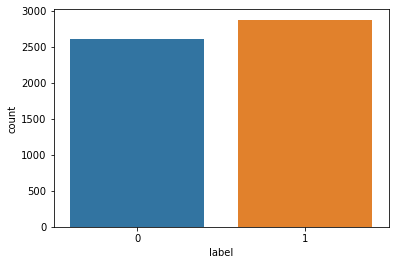

In [31]:
sns.countplot(x='label', data=df1)

- data type 변경

In [32]:
# data type : int -> string
df1 = df1.astype({'일자':'string'})
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5484 entries, 0 to 5483
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   일자         5484 non-null   string 
 1   현재가        5484 non-null   int64  
 2   당일종가-어제종가  5484 non-null   int64  
 3   상승률        5484 non-null   float64
 4   label      5484 non-null   int64  
dtypes: float64(1), int64(3), string(1)
memory usage: 214.3 KB


In [33]:
# data type : string -> datetime
df1['일자'] = pd.to_datetime(df1['일자'])
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5484 entries, 0 to 5483
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   일자         5484 non-null   datetime64[ns]
 1   현재가        5484 non-null   int64         
 2   당일종가-어제종가  5484 non-null   int64         
 3   상승률        5484 non-null   float64       
 4   label      5484 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 214.3 KB


### 4-2. 뉴스데이터 컬럼명 변경

In [34]:
# 덕산네오룩스의 데이터프레임과 병합하기 위해 컬럼명 변경
newsdata_all.rename(columns={'NextOpenDate':'일자'}, inplace=True)
newsdata_all.head(2)

,date,NextOpenDateYear,일자,title
0,2022-03-16,2022,2022-03-17,"유럽 반도체 공급망 지원 호응… 인텔, 10년간 110조 통큰 투자"
1,2022-03-16,2022,2022-03-17,반도체 또다시 ‘쩐의 전쟁‘…인텔 “유럽 전역에 110조 투자”


### 4-3. 뉴스데이터와 덕산네오룩스 주가데이터 병합

In [35]:
merge_data = pd.merge(newsdata_all, df1, on='일자', how='inner')
merge_data.head(2)

,date,NextOpenDateYear,일자,title,현재가,당일종가-어제종가,상승률,label
0,2022-03-13,2022,2022-03-14,전함 포템킨·오데사·네온사인…반도체는 왜 또 위기일까[인더독],31900,-1500,-0.047022,0
1,2022-03-13,2022,2022-03-14,"한국기업, 반도체·전자 부품 조달 ‘빨간불’",31900,-1500,-0.047022,0


- '일자', 'title', 'label'만 남긴 나머지 컬럼 삭제

In [36]:
merge_data = merge_data[['일자', 'title', 'label']]
merge_data.head(5)

,일자,title,label
0,2022-03-14,전함 포템킨·오데사·네온사인…반도체는 왜 또 위기일까[인더독],0
1,2022-03-14,"한국기업, 반도체·전자 부품 조달 ‘빨간불’",0
2,2022-03-14,“삼성·SK만 잘하면 뭐해?” 한국 반도체 진짜 ‘약점’이 바로 [비즈360],0
3,2022-03-14,"""반도체 일본꼴 날 수도…수도권 대학 반도체학과 정원 풀어야"" [당선인에 바란다]",0
4,2022-03-14,"[우크라 침공] 러시아, 반도체소자 등 500개 품목 대외수출 금지·제한",0


## 5. 데이터 전처리
    - 한글 이외의 문자열은 빈칸(`''`)처리
    - 품사 중 명사만 추출하여 'nouns' 컬럼에 삽입

In [37]:
okt = Okt()
n_ = []

for i in range(len(merge_data)):
    if (i % 10000 == 0):
        print(i, "단계 완료")
    n_.append(okt.nouns(merge_data.iloc[i]['title']))
merge_data['nouns'] = n_
merge_data = merge_data[merge_data['nouns'] != '']

# 2차 불용어 제거
merge_data['title'] = merge_data['title'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]','')
merge_data['title'].replace('', np.nan, inplace=True)
merge_data = merge_data.dropna(how='any')

0 단계 완료
10000 단계 완료
20000 단계 완료
30000 단계 완료
40000 단계 완료
50000 단계 완료


In [40]:
news_labeling = merge_data.copy()

- label 분포 확인

<AxesSubplot:xlabel='label', ylabel='count'>

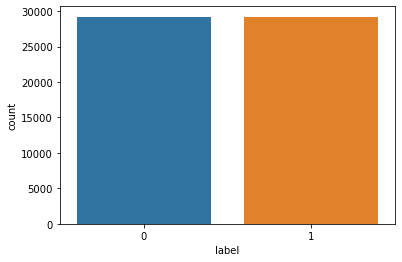

In [39]:
sns.countplot(x='label', data=merge_data)